In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statistics import mean, stdev
import sys
import os
if "../" not in sys.path:
  sys.path.append("../") 
os.chdir("..") 
from envs.data_handler import DataHandler
import envs.data_utils as du

dh = DataHandler(data_generation='Linear', take_component_id=True, transformation='raw')
dh.data.head()

,Optimal_Affected_Component_Uid,Optimal_Failure,raw
0,_SEwwu-cdEeet0YmmfbMwkw,CF1,49.5
1,_SExXgOcdEeet0YmmfbMwkw,CF2,16.0
2,_SEx_HucdEeet0YmmfbMwkw,CF3,31.5
3,_SEymDucdEeet0YmmfbMwkw,CF3,25.0
4,_SExYKucdEeet0YmmfbMwkw,CF3,16.0


# Data Shift

* Step 1: Calculate the Standard Deviation
* Step 2: Create the ordering by the mean value for each <component,failure> group and sort them ascending by mean value, component name, failure name
* Step 3: Shift data

In [2]:
data_new = du.shift_data(dh.data)  
data_new.head()

,Optimal_Affected_Component_Uid,Optimal_Failure,raw
0,_SEwwu-cdEeet0YmmfbMwkw,CF1,140.8855
1,_SExXgOcdEeet0YmmfbMwkw,CF2,25.5459
2,_SEx_HucdEeet0YmmfbMwkw,CF3,60.8449
3,_SEymDucdEeet0YmmfbMwkw,CF3,49.3952
4,_SExYKucdEeet0YmmfbMwkw,CF3,25.5459


Perform T-Test:

In [3]:
ttest = du.execute_ttest(data_new)
num_distinguishable_pairs = len(ttest[ttest['pvalue']<0.05])
total = len(ttest.index) - 2
print('{0} of the {1} <component, failure> combination pairs are statistical significant'.format(num_distinguishable_pairs, total))

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3505: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


22 of the 912 <component, failure> combination pairs are statistical significant


# Parameterization

Evaluate different spread mulitplication factors for an optimal shifting for each of the transformed datasets (e.g. cube/square root transfromation):

\begin{align}
x_{new} = x_{old} + f * (\sigma(x_{-1}) + \sigma(x))
\end{align}

where $x_{old}$ is the original value from a certain dataset related to <component,failure> and needs to be shifted. Here, we evaluate different values for $f \in \mathbb{N}^{+}$ as the spread mulitplication factor which is mulitplied with the standard deviation of the previous <component,failure> combination $\sigma(x_{-1})$ and of the current one $\sigma(x)$. 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3505: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'raw': (231, 51), 'cube': (221, 52), 'sqt': (241, 48), 'log10': (201, 55), 'ln': (201, 45), 'log2': (201, 54)}


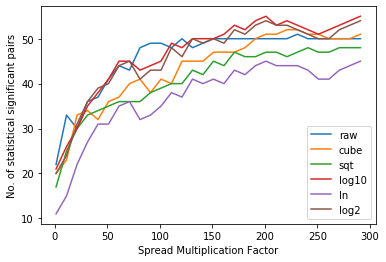

In [2]:
result = {}

trans = ['raw', 'cube', 'sqt', 'log10', 'ln', 'log2']
factor = range(1, 300, 10)

for t in trans:
    X = []
    Y = []
    
    # initialize the result dictionary for each transformation
    if t not in result:
        result[t] = (0,0) # (spread_multiplication_factor, number of statistical significant pairs) 
    
    # evaluate the different spread mulitplication factors
    for f in factor:
        
        # load the data 
        dh = DataHandler(data_generation='Linear', take_component_id=True, transformation=t)
        shifted_data = du.shift_data(dh.data, spread_multiplication_factor=f)
        ttest = du.execute_ttest(shifted_data)
        num_significant_pairs = len(ttest[ttest['pvalue']<0.05])

        # save the results for plotting
        X.append(f) # factor
        Y.append(num_significant_pairs) # number of statistical significant pairs

        if num_significant_pairs > result[t][1]:
            # we were able to generate at least one more statistical significant pair
            result[t] = (f, num_significant_pairs)

        print("{0}: With the spread multiplication factor of {1} we have {2} statistical significant pairs.    ".format(t, f, num_significant_pairs), end="\r")

    plt.plot(X, Y, label=t)


print(result)
plt.xlabel("Spread Multiplication Factor")
plt.ylabel("No. of statistical significant pairs")
plt.legend()
plt.savefig('data_analysis/shifting_parameter_evaluation.pdf') 
plt.show()

And then saving optimal shifted data to csv

In [4]:
result = {'raw': (231, 51), 'cube': (221, 52), 'sqt': (241, 48), 'log10': (201, 55), 'ln': (201, 45), 'log2': (201, 54)}
dh = DataHandler(data_generation='Linear', take_component_id=True, transformation='raw')
optimal_shifted_data = dh.data[[dh.data.columns[0], dh.data.columns[1]]]

for t, value in result.items():
    dh = DataHandler(data_generation='Linear', take_component_id=True, transformation=t)
    data = du.shift_data(dh.data, spread_multiplication_factor=value[0])
    ttest = du.execute_ttest(data)
    print("Shifting {0} data with a factor of {1} results in {2} distinguishable pairs.".format(t, value[0], len(ttest[ttest['pvalue']<0.05])))
    optimal_shifted_data = optimal_shifted_data.merge(data[[data.columns[2]]], how='outer', left_index=True, right_index=True)
    
optimal_shifted_data.to_csv('data/prepared_data/LinearShifted_Id.csv')
print("Data saved.")

Shifting raw data with a factor of 231 results in 51 distinguishable pairs.
Shifting cube data with a factor of 221 results in 52 distinguishable pairs.
Shifting sqt data with a factor of 241 results in 48 distinguishable pairs.
Shifting log10 data with a factor of 201 results in 55 distinguishable pairs.
Shifting ln data with a factor of 201 results in 45 distinguishable pairs.
Shifting log2 data with a factor of 201 results in 54 distinguishable pairs.
Data saved.


In [5]:
dh = DataHandler(data_generation='LinearShifted', take_component_id=True, transformation='log10')
ttest_2 = du.execute_ttest(dh.data)
print(len(ttest_2[ttest_2['pvalue']<0.05]))

56
